In [1]:
import tensorflow as tf
import numpy as np
import vgg19
import matplotlib.pyplot as plt
import utils

In [2]:
#img = tf.placeholder(tf.float32, [None, 224, 224, 3])
i_max = 1000
i_print = 100

#0.5 - noise , 0.5 + noise
noise_weight = 0.1

device = '/gpu:0'
show = True

#layers = [vgg.pool4, vgg.pool3, vgg.pool2, vgg.pool1, vgg.conv1_1]
style_weight = [0.2, 0.5, 0.9, 1.0, 1.0]

In [3]:
def gram_matrix(F, N, M):
    Ft = tf.reshape(F, (M, N))
    if M < N:
        return tf.matmul(Ft,tf.transpose(Ft))
    else:
        return tf.matmul(tf.transpose(Ft), Ft)

In [4]:
def main_loss_function(x):
    return

In [5]:
def create_noise_image(width, height):
    image = np.random.uniform(0.5 - noise_weight,0.5 + noise_weight, (1, height, width, 3)).astype('float32')
    
    if(show == True):
        plt.imshow(image.reshape(height,width,3))
        plt.show()
    return image

In [6]:
def get_image(path):
    #load image
    img_input = utils.load_image(path)
    img = img_input.reshape((1, 224, 224, 3))
    
    #show image
    if(show == True):
        plt.imshow(img_input.reshape((224,224,3)))
        plt.show()
        
    return img

In [7]:
def get_layers(image, scope):      
    #vgg
    vgg = vgg19.Vgg19()
    
    with tf.name_scope(scope):
        vgg.build(image)

    layers = [vgg.pool4, vgg.pool3, vgg.pool2, vgg.pool1, vgg.conv1_1]
    #layers = [vgg.conv1_1]
    
    return layers

In [8]:
def get_gram_loss(target_layers, input_layers):
    gram_losses = []
    #go through layers
    for tl, il, w in zip(target_layers, input_layers, style_weight):
        #get dimensions
        dimensions = tl.get_shape().as_list()
        size = dimensions[3]*dimensions[2]*dimensions[1]
        
        #get gram
        target_gram = gram_matrix(tl, dimensions[3], dimensions[2]*dimensions[1])
        input_gram = gram_matrix(il, dimensions[3], dimensions[2]*dimensions[1])
        #gram_losses.append(tf.nn.l2_loss(target_gram))
        #gram_losses.append(tf.nn.l2_loss(input_gram))
        
        #get losses
        gram_losses.append(w * tf.log(tf.reduce_sum(tf.square(target_gram - input_gram)) / size ))
    
    #get gram_loss
    gram_loss = tf.reduce_sum(gram_losses)
    
    return gram_losses

In [9]:
def get_loss(target_layers, input_layers):
    loss = 0
    losses = []
    
    #gram loss
    gram_loss = get_gram_loss(target_layers, input_layers) 
    
    #get histogram matrices
    
    
    

    return gram_loss

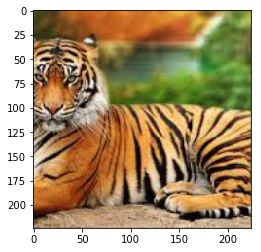

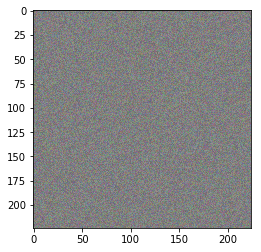

/home/rwjoverwater/in4015/vgg19.npy
npy file loaded
build model started
build model finished: 0s
/home/rwjoverwater/in4015/vgg19.npy
npy file loaded
build model started
build model finished: 0s


In [10]:
with tf.device(device):
    sess = tf.InteractiveSession()
        
    #placeholders
    input_image = tf.placeholder(tf.float32, [1, 224, 224, 3])
    
    #load style image
    input_img = get_image("./test_data/tiger.jpeg")
    #create target image
    target_img = (create_noise_image(224, 224))
        
    #fill feed dictionary
    feed = {input_image: input_img}
                 
    #create variables                 
    target = tf.Variable(target_img, tf.float32)
            
    #input vgg
    style_layers = get_layers(input_image, "style")
    #target vgg
    target_layers = get_layers(target, "target")
    
    #get losses
    loss = tf.reduce_sum(get_loss(target_layers, style_layers))
    


122.78
[6.4088054, 20.12594, 32.135696, 34.81208, 29.29767]


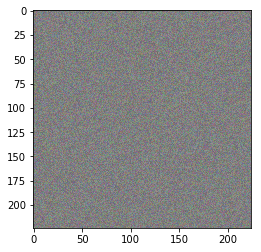

In [11]:
    
    #handlers
    optimizer = tf.train.GradientDescentOptimizer(1.0)
    minimize = optimizer.minimize(loss)
    
    #init
    sess.run(tf.global_variables_initializer())
    
    
    print(sess.run(loss, feed_dict = feed))
    print(sess.run(get_loss(target_layers, style_layers), feed_dict = feed))
    
    #show image
    if(show == True):
        plt.imshow(sess.run(tf.reshape(target,(224,224,3)), feed_dict = feed))
        plt.show()
    

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
106.883
[6.0820932, 17.523993, 26.977268, 30.368666, 25.931387]


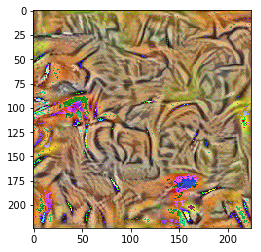

100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 
105.452
[6.0910196, 17.440037, 26.965557, 29.649488, 25.305588]


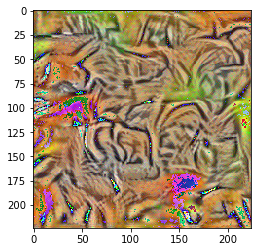

200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 
104.275
[6.092464, 17.369503, 27.151613, 29.042702, 24.618525]


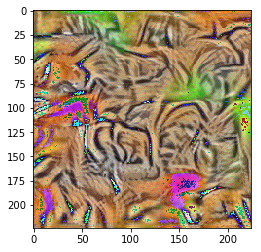

300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 

In [ ]:
    for i in range(i_max):
        
        #optimize step
        sess.run(minimize, feed_dict = feed)
        tf.minimum(tf.maximum(target,1),0.0)
        
        print(i, end = '')
        print(' ', end = '')
        
        if((i+1) % i_print == 0):
            
            #print loss
            #print(sess.run(target_layers, feed_dict = feed))
            print('')
            print(sess.run(loss, feed_dict = feed))
            print(sess.run(get_loss(target_layers, style_layers), feed_dict = feed))

            #show image
            if(show == True):
                plt.imshow(sess.run(tf.reshape(target,(224,224,3)), feed_dict = feed))
                plt.show()

    
